# Correlation Checking Strategies

## Pre-processing

### Installing Requirements and import libraries

In [17]:
pip install -r requirements.txt

In [18]:
import os
import pandas as pd
import numpy as np
from collections import OrderedDict
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from typing import List, Dict, Optional
from numpy.linalg import pinv
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Lasso
import shap

### Defining some useful function

### Matrices Extraction

#### Extracting dataframes from .csv files

In [19]:
def extract_matrix_from_csv(file_path):
    df = pd.read_csv(file_path, header=None)
    matrix = df.values
    return matrix

def save_matrix_to_csv(matrix, output_path):
    df = pd.DataFrame(matrix)
    df.to_csv(output_path, index=False, header=False)

In [20]:
df_concat_final = extract_matrix_from_csv('data/raw/df_concat_final.csv')

feature_imporance_prod_final = extract_matrix_from_csv('data/raw/feature_importance_prod_final.csv')

graph_embeddings = extract_matrix_from_csv('data/raw/graph_embeddings.csv')

subj_embeddings_train = extract_matrix_from_csv('data/raw/subj_embeddings_train.csv')

C:\Users\e1204\AppData\Local\Temp\ipykernel_4280\3658579915.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

#### Extract the P matrix

In [21]:
df = pd.read_csv('data/raw/subj_embeddings_train.csv')


In [22]:
# save the values of the first column as a list
P_patients = df.iloc[:, 0].tolist()

print(P_patients)  

['AD_0001', 'AD_0002', 'AD_0003', 'AD_0005', 'AD_0006', 'AD_0007', 'AD_0008', 'AD_0009', 'AD_0010', 'AD_0011', 'AD_0012', 'AD_0013', 'AD_0014', 'AD_0015', 'AD_0016', 'AD_0020', 'AD_0021', 'AD_0023', 'AD_0024', 'AD_0026', 'AD_0028', 'AD_0029', 'AD_0031', 'AD_0032', 'AD_0033', 'AD_0034', 'AD_0035', 'AD_0036', 'AD_0037', 'AD_0038', 'AD_0039', 'AD_0040', 'AD_0041', 'AD_0042', 'AD_0043', 'AD_0044', 'AD_0045', 'AD_0046', 'AD_0048', 'AD_0050', 'AD_0051', 'AD_0052', 'AD_0054', 'AD_0056', 'AD_0057', 'AD_0058', 'AD_0059', 'AD_0060', 'AD_0061', 'AD_0062', 'AD_0063', 'AD_0066', 'AD_0067', 'AD_0068', 'AD_0070', 'AD_0071', 'AD_0072', 'AD_0073', 'AD_0074', 'AD_0075', 'AD_0077', 'AD_0079', 'AD_0081', 'AD_0082', 'AD_0083', 'AD_0084', 'AD_0085', 'AD_0086', 'AD_0087', 'AD_0089', 'AD_0091', 'AD_0092', 'AD_0093', 'AD_0094', 'AD_0098', 'AD_0100', 'AD_0101', 'AD_0103', 'AD_0104', 'AD_0105', 'AD_0106', 'AD_0107', 'AD_0108', 'AD_0109', 'AD_0110', 'AD_0111', 'AD_0112', 'AD_0113', 'AD_0114', 'AD_0115', 'AD_0116'

In [23]:
# compute P as the ndarray of df
P = df.values[:, 1:]

#### Extract the X matrix

In [24]:
df = pd.read_csv('data/raw/df_concat_final.csv') 

# rename the first column of df
df.rename(columns={df.columns[0]: 'patient_id'}, inplace=True)

patient_info_list = ['patient_id', 'country', 'age', 'sex', 'sex', 'apoe4', 'disease']

df_subset = df[patient_info_list]

# remove the extra column named 'sex' (there are two columns with the same name and same values)
df_subset = df_subset.loc[:, ~df_subset.columns.duplicated()]

df_subset.to_csv('data/result/patient_info.csv', index=False)

In [25]:
# save the values of the first column as a list
X_patients = df_subset.iloc[:, 0].tolist()
print(X_patients)

['AD_0001', 'AD_0002', 'AD_0003', 'AD_0005', 'AD_0006', 'AD_0007', 'AD_0008', 'AD_0009', 'AD_0010', 'AD_0011', 'AD_0012', 'AD_0013', 'AD_0014', 'AD_0015', 'AD_0016', 'AD_0020', 'AD_0021', 'AD_0023', 'AD_0024', 'AD_0026', 'AD_0028', 'AD_0029', 'AD_0031', 'AD_0032', 'AD_0033', 'AD_0034', 'AD_0035', 'AD_0036', 'AD_0037', 'AD_0038', 'AD_0039', 'AD_0040', 'AD_0041', 'AD_0042', 'AD_0043', 'AD_0044', 'AD_0045', 'AD_0046', 'AD_0048', 'AD_0050', 'AD_0051', 'AD_0052', 'AD_0054', 'AD_0056', 'AD_0057', 'AD_0058', 'AD_0059', 'AD_0060', 'AD_0061', 'AD_0062', 'AD_0063', 'AD_0066', 'AD_0067', 'AD_0068', 'AD_0070', 'AD_0071', 'AD_0072', 'AD_0073', 'AD_0074', 'AD_0075', 'AD_0077', 'AD_0079', 'AD_0081', 'AD_0082', 'AD_0083', 'AD_0084', 'AD_0085', 'AD_0086', 'AD_0087', 'AD_0089', 'AD_0091', 'AD_0092', 'AD_0093', 'AD_0094', 'AD_0098', 'AD_0100', 'AD_0101', 'AD_0103', 'AD_0104', 'AD_0105', 'AD_0106', 'AD_0107', 'AD_0108', 'AD_0109', 'AD_0110', 'AD_0111', 'AD_0112', 'AD_0113', 'AD_0114', 'AD_0115', 'AD_0116'

In [26]:
# remove the columns in df being in patient_info_list
df = df.drop(columns=patient_info_list)

print(df.shape)

(1256, 2604)


In [27]:
# save the names of the remaining columns as a list
X_features = df_subset.columns[1:].tolist()
print(X_features)

['country', 'age', 'sex', 'apoe4', 'disease']


In [28]:
# get the list of columns containing at least one NaN value
nan_columns = df.columns[df.isnull().any()].tolist()

# save the column names in df being in nan_columns in a list
nan_columns_list = nan_columns.copy()

# remove the columns in df being in nan_columns
df = df.drop(columns=nan_columns)

X = df.values

In [29]:
# save the column names in df not being in nan_columns in a list
X_miRNA = df.columns.tolist()
print(X_miRNA)

['hsa-let-7a-5p', 'hsa-let-7b-5p', 'hsa-let-7c-5p', 'hsa-let-7d-5p', 'hsa-let-7e-5p', 'hsa-let-7f-5p', 'hsa-miR-15a-5p', 'hsa-miR-16-5p', 'hsa-miR-17-5p', 'hsa-miR-17-3p', 'hsa-miR-18a-5p', 'hsa-miR-19a-3p', 'hsa-miR-19b-3p', 'hsa-miR-20a-5p', 'hsa-miR-21-5p', 'hsa-miR-22-3p', 'hsa-miR-23a-3p', 'hsa-miR-24-1-5p', 'hsa-miR-24-3p', 'hsa-miR-25-3p', 'hsa-miR-26a-5p', 'hsa-miR-26b-5p', 'hsa-miR-27a-3p', 'hsa-miR-28-5p', 'hsa-miR-29a-3p', 'hsa-miR-30a-5p', 'hsa-miR-30a-3p', 'hsa-miR-31-5p', 'hsa-miR-32-5p', 'hsa-miR-33a-5p', 'hsa-miR-92a-3p', 'hsa-miR-93-5p', 'hsa-miR-95-3p', 'hsa-miR-96-5p', 'hsa-miR-98-5p', 'hsa-miR-99a-5p', 'hsa-miR-100-5p', 'hsa-miR-101-3p', 'hsa-miR-29b-3p', 'hsa-miR-103a-3p', 'hsa-miR-105-5p', 'hsa-miR-106a-5p', 'hsa-miR-107', 'hsa-miR-192-5p', 'hsa-miR-196a-5p', 'hsa-miR-197-3p', 'hsa-miR-198', 'hsa-miR-199a-5p', 'hsa-miR-199a-3p', 'hsa-miR-208a-3p', 'hsa-miR-129-5p', 'hsa-miR-148a-3p', 'hsa-miR-30c-5p', 'hsa-miR-30d-5p', 'hsa-miR-139-5p', 'hsa-miR-147a', 'hsa-miR-7-

#### Extract the H matrix

In [30]:
df_ge = pd.read_csv('data/raw/graph_embeddings.csv')
df_cf = pd.read_csv('data/raw/df_concat_final.csv')

# extract the column names from df_cf
column_names = df_cf.columns.tolist()

# print column names length
print(len(column_names))

# remove 'Unnamed: 0' from the list of column names
if 'Unnamed: 0' in column_names:
    column_names.remove('Unnamed: 0')

print(column_names)

# check if there any duplicate column names in column_names
duplicate_columns = set([x for x in column_names if column_names.count(x) > 1])
print(duplicate_columns)

# delete all the rows in df_ge where 'Unnamed: 0' is not equal to a value in column_names
df_ge = df_ge[df_ge['Unnamed: 0'].isin(column_names)]

# check if there are any rows in ge with the same 'Unnamed: 0' value
duplicates = df_ge.duplicated(subset=['Unnamed: 0'], keep=False)

# delete the rows in df_ge where 'Unnamed: 0' is duplicated
df_ge = df_ge[~duplicates]
df_ge = df_ge.reset_index(drop=True)

# delete the rows in df_ge where 'Unnamed: 0' is a value in nan_columns_list
df_ge = df_ge[~df_ge['Unnamed: 0'].isin(nan_columns_list)]

H = df_ge.drop(columns=['Unnamed: 0']).values

2610
['hsa-let-7a-5p', 'hsa-let-7b-5p', 'hsa-let-7c-5p', 'hsa-let-7d-5p', 'hsa-let-7e-5p', 'hsa-let-7f-5p', 'hsa-miR-15a-5p', 'hsa-miR-16-5p', 'hsa-miR-17-5p', 'hsa-miR-17-3p', 'hsa-miR-18a-5p', 'hsa-miR-19a-3p', 'hsa-miR-19b-3p', 'hsa-miR-20a-5p', 'hsa-miR-21-5p', 'hsa-miR-22-3p', 'hsa-miR-23a-3p', 'hsa-miR-24-1-5p', 'hsa-miR-24-3p', 'hsa-miR-25-3p', 'hsa-miR-26a-5p', 'hsa-miR-26b-5p', 'hsa-miR-27a-3p', 'hsa-miR-28-5p', 'hsa-miR-29a-3p', 'hsa-miR-30a-5p', 'hsa-miR-30a-3p', 'hsa-miR-31-5p', 'hsa-miR-32-5p', 'hsa-miR-33a-5p', 'hsa-miR-92a-3p', 'hsa-miR-93-5p', 'hsa-miR-95-3p', 'hsa-miR-96-5p', 'hsa-miR-98-5p', 'hsa-miR-99a-5p', 'hsa-miR-100-5p', 'hsa-miR-101-3p', 'hsa-miR-29b-3p', 'hsa-miR-103a-3p', 'hsa-miR-105-5p', 'hsa-miR-106a-5p', 'hsa-miR-107', 'hsa-miR-192-5p', 'hsa-miR-196a-5p', 'hsa-miR-197-3p', 'hsa-miR-198', 'hsa-miR-199a-5p', 'hsa-miR-199a-3p', 'hsa-miR-208a-3p', 'hsa-miR-129-5p', 'hsa-miR-148a-3p', 'hsa-miR-30c-5p', 'hsa-miR-30d-5p', 'hsa-miR-139-5p', 'hsa-miR-147a', 'hsa-m

In [31]:
# save the values of the first column as a list
row_names_list = df_ge.iloc[:, 0].tolist()

H_miRNA = row_names_list.copy()

print(H_miRNA)

['hsa-let-7a-5p', 'hsa-let-7b-5p', 'hsa-let-7c-5p', 'hsa-let-7d-5p', 'hsa-let-7e-5p', 'hsa-let-7f-5p', 'hsa-miR-15a-5p', 'hsa-miR-16-5p', 'hsa-miR-17-5p', 'hsa-miR-17-3p', 'hsa-miR-18a-5p', 'hsa-miR-19a-3p', 'hsa-miR-19b-3p', 'hsa-miR-20a-5p', 'hsa-miR-21-5p', 'hsa-miR-22-3p', 'hsa-miR-23a-3p', 'hsa-miR-24-1-5p', 'hsa-miR-24-3p', 'hsa-miR-25-3p', 'hsa-miR-26a-5p', 'hsa-miR-26b-5p', 'hsa-miR-27a-3p', 'hsa-miR-28-5p', 'hsa-miR-29a-3p', 'hsa-miR-30a-5p', 'hsa-miR-30a-3p', 'hsa-miR-31-5p', 'hsa-miR-32-5p', 'hsa-miR-33a-5p', 'hsa-miR-92a-3p', 'hsa-miR-93-5p', 'hsa-miR-95-3p', 'hsa-miR-96-5p', 'hsa-miR-98-5p', 'hsa-miR-99a-5p', 'hsa-miR-100-5p', 'hsa-miR-101-3p', 'hsa-miR-29b-3p', 'hsa-miR-103a-3p', 'hsa-miR-105-5p', 'hsa-miR-106a-5p', 'hsa-miR-107', 'hsa-miR-192-5p', 'hsa-miR-196a-5p', 'hsa-miR-197-3p', 'hsa-miR-198', 'hsa-miR-199a-5p', 'hsa-miR-199a-3p', 'hsa-miR-208a-3p', 'hsa-miR-129-5p', 'hsa-miR-148a-3p', 'hsa-miR-30c-5p', 'hsa-miR-30d-5p', 'hsa-miR-139-5p', 'hsa-miR-147a', 'hsa-miR-7-

#### Extract the Feature Importance

In [32]:
df = pd.read_csv('data/raw/feature_importance_prod_final.csv')

# sort the dataframe by the integer values of the column "Feature"
df['Feature'] = df['Feature'].astype(int)
df = df.sort_values(by='Feature')

# remove the "Importance" column
df = df.drop(columns=['Importance'])

# obtain a new .csv file with the sorted dataframe
df.to_csv('data/result/feature_importance_sorted.csv', index=False)

feature_importance = df.values[:, 1:]  # Exclude the 'Feature' column

## Analysis of initial data

### Verifying if P = X * H

In [15]:
print(P.shape)
print(X.shape)
print(H.shape)

(1256, 128)
(1256, 2558)
(2558, 128)


In [38]:
# check if X_miRNA and H_miRNA are the same
if X_miRNA == H_miRNA:
    print("X_miRNA and H_miRNA are the same.")
else:
    print("X_miRNA and H_miRNA are different.")

# check if P_patients and X_patients are the same
if P_patients == X_patients:
    print("P_patients and X_patients are the same.")
else:
    print("P_patients and X_patients are different.")

X_miRNA and H_miRNA are the same.
P_patients and X_patients are the same.


In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

P_hat = X @ H                           # n_paz × 128
R2_global = r2_score(P.ravel(), P_hat.ravel())
MSE_global = mean_squared_error(P, P_hat)

print("R² global  :", R2_global)
print("MSE global :", MSE_global)


R² globale  : -107920739.21457087
MSE globale : 1554301.665152844


In [40]:
scaler_X = StandardScaler().fit(X)
scaler_P = StandardScaler().fit(P)

Xz = scaler_X.transform(X)    # shape (n, m)
Pz = scaler_P.transform(P)    # shape (n, 128)

In [41]:
print(X.shape, P.shape)


(1256, 2558) (1256, 128)


In [ ]:
from numpy.linalg import pinv

W_pinv = pinv(Xz) @ Pz        # shape (m, 128)  (m = n° miRNA)
P_hat  = Xz @ W_pinv          # rebuilding P from X

# R² globale
from sklearn.metrics import r2_score
r2_pinv = r2_score(Pz.ravel(), P_hat.ravel())
print("R² pseudo-inverse:", r2_pinv)


R² pseudoinversa: 1.0


## Correlation Analysis

### Pseudo-inverse Coefficients computation

In [89]:
importance_df = pd.read_csv("data/result/feature_importance_sorted.csv")
importance_df = importance_df.sort_values(by="Normalized_Importance", ascending=False)
top_features = importance_df["Feature"].values

scaler_X = StandardScaler()
scaler_P = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
P_scaled = scaler_P.fit_transform(P)

In [ ]:
# Pseudo‑inverse computation
X_pinv = pinv(X_scaled)          
W_full = X_pinv @ P_scaled       
W_full = W_full.T               

In [ ]:
# Computing importance of each miRNA
importance = np.linalg.norm(W_full, axis=0)   
miRNA_rank = np.argsort(importance)[::-1]     
importance_sorted = importance[miRNA_rank]
miRNA_sorted = [X_miRNA[i] for i in miRNA_rank]

list(zip(miRNA_sorted[:10], importance_sorted[:10]))


[('hsa-miR-6729-5p', 3.502095081509349),
 ('hsa-miR-1908-5p', 3.004297624786519),
 ('hsa-miR-371a-5p', 2.473545699725709),
 ('hsa-miR-7704', 2.457462590707732),
 ('hsa-miR-6780a-3p', 2.4036474642084844),
 ('hsa-miR-4734', 2.205871573863652),
 ('hsa-miR-5787', 1.7557656150002763),
 ('hsa-miR-6895-5p', 1.5466965590461002),
 ('hsa-miR-4787-5p', 1.5293416115589757),
 ('hsa-miR-4306', 1.4447031307918008)]

In [ ]:
top_k = 300              
keep_idx = miRNA_rank[:top_k]

# reducing X and W
X_reduced = X_scaled[:, keep_idx]       
W_reduced = W_full[:, keep_idx]         
miRNA_kept = [X_miRNA[i] for i in keep_idx]


In [ ]:
df_W = pd.DataFrame(W_reduced, columns=miRNA_kept)   
df_W.insert(0, "Feature", np.arange(W_reduced.shape[0]))  

df_W.to_csv("data/result/W_reduced_df.csv", index=False)

# quick‑look
df_W.head()

,Feature,hsa-miR-6729-5p,hsa-miR-1908-5p,hsa-miR-371a-5p,hsa-miR-7704,hsa-miR-6780a-3p,hsa-miR-4734,hsa-miR-5787,hsa-miR-6895-5p,hsa-miR-4787-5p,...,hsa-miR-373-5p,hsa-miR-6503-3p,hsa-miR-4276,hsa-miR-664b-3p,hsa-miR-488-5p,hsa-miR-4694-3p,hsa-miR-15b-5p,hsa-miR-365b-5p,hsa-miR-5004-3p,hsa-miR-1537-3p
0,0,0.415714,0.312788,0.008623,-0.274129,0.016153,-0.236107,0.208192,0.125542,-0.090651,...,0.009384,-0.007995,0.011878,-0.012263,0.012729,0.011811,-0.004501,-0.010422,0.003824,-0.008791
1,1,-0.322127,-0.470224,-0.031652,0.066140,-0.136258,0.241822,-0.090200,-0.001507,0.147857,...,-0.008795,0.012553,-0.015372,0.007738,-0.010038,-0.012000,-0.005061,0.010615,-0.013733,0.017351
2,2,0.450412,0.452065,-0.176897,0.172475,-0.151520,-0.009848,0.227935,0.186173,-0.320977,...,0.001083,-0.000727,0.012528,0.001748,0.005213,0.003778,0.010045,0.000713,0.008646,-0.020020
3,3,0.128500,0.385434,0.137096,-0.438557,0.148141,-0.220072,0.130093,0.038012,-0.019341,...,0.010496,-0.010140,0.012863,-0.014803,0.012049,0.011293,-0.006942,-0.007735,0.010366,-0.009251
4,4,0.348361,0.290261,-0.148117,-0.146093,0.089232,-0.342603,0.024843,0.277240,-0.035659,...,0.012941,-0.013564,0.007643,-0.004532,0.013262,0.012684,-0.005637,-0.012763,0.012152,-0.007141


In [97]:
P_hat = X_reduced @ W_reduced.T
mse = mean_squared_error(P_scaled, P_hat)
r2 = r2_score(P_scaled, P_hat)
print(f"Top‑k = {top_k} →   MSE = {mse:.4f}   |   R² = {r2:.4f}")


Top‑k = 300 →   MSE = 0.0729   |   R² = 0.9271


### Lasso Coefficients computation

#### Computing the behavior for the most important features in predicting patients state

In [ ]:
start = 0   # Initial feature index (included)
end = 20    # final feature index (not included)

# extracting the top features based on the feature importance in a previous classification
importance_df = pd.read_csv("data/result/feature_importance_sorted.csv")
importance_df = importance_df.sort_values(by="Normalized_Importance", ascending=False)
top_features = importance_df["Feature"].values  

selected_features = top_features[start:end]
batch_k = len(selected_features)

scaler_X = StandardScaler()
scaler_P = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
P_scaled = scaler_P.fit_transform(P)

coeff_matrix = np.zeros((batch_k, X.shape[1]))

print(f"\nEseguo Lasso per le feature da posizione {start} a {end - 1}:")
for i, feat_idx in tqdm(enumerate(selected_features), total=batch_k, desc="Batch Lasso", unit="feature"):
    y = P_scaled[:, feat_idx]
    lasso = LassoCV(cv=5, max_iter=10000)
    lasso.fit(X_scaled, y)
    coeff_matrix[i, :] = lasso.coef_

coeff_df = pd.DataFrame(
    coeff_matrix,
    index=[f"Feature_{i}" for i in selected_features],
    columns=row_names_list  
)

output_path = "data/result/lasso_coefficients_incremental.csv"

if os.path.exists(output_path):
    existing = pd.read_csv(output_path, index_col=0)
    combined = pd.concat([existing, coeff_df])
    combined.to_csv(output_path)
else:
    coeff_df.to_csv(output_path)

print(f"✔️ Coefficienti salvati (range {start}-{end-1}) in: {output_path}")


#### Re-training Lasso on a reduced dataset

In [107]:
coeff_df = pd.read_csv("data/result/lasso_coefficients_incremental.csv", index_col=0)

# threshold = 1e-2

# # Compute the sum of absolute values for each miRNA (columns = miRNA)
# miRNA_influenza = coeff_df.abs().sum(axis=0)

# # miRNA to keep: at least one feature with significant coefficient
# miRNA_keep = miRNA_influenza[miRNA_influenza > threshold].index.tolist()

# # miRNA to drop: all features with coefficients below the threshold
# miRNA_drop = miRNA_influenza[miRNA_influenza <= threshold].index.tolist()

# # print the length of the miRNA lists
# print(f"MiRNA to keep: {len(miRNA_keep)}")

miRNA_influenza = coeff_df.abs().sum(axis=0) 

miRNA_ranked = miRNA_influenza.sort_values(ascending=False)
miRNA_keep = miRNA_ranked.head(top_k).index.tolist()

In [108]:
df_miRNA = pd.read_csv("data/raw/df_concat_final.csv", index_col=0)

miRNA_keep_sorted = [m for m in df_miRNA.columns if m in miRNA_keep]

df_miRNA_filtered = df_miRNA[miRNA_keep_sorted]

df_target = pd.read_csv("data/raw/subj_embeddings_train.csv", index_col=0)

print(df_miRNA_filtered.shape)

(1256, 300)


In [109]:
# Convert to numpy arrays
X = df_miRNA_filtered.values
P = df_target.values

# Standardize the data
scaler_X = StandardScaler()
scaler_P = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
P_scaled = scaler_P.fit_transform(P)

n_feat = P.shape[1]
coeff_matrix = np.zeros((n_feat, X.shape[1]))

print("Eseguo Lasso su tutte le 127 feature target:")
for i in tqdm(range(n_feat), desc="Lasso regressions", unit="feature"):
    y = P_scaled[:, i]
    lasso = LassoCV(cv=5, max_iter=10000)
    lasso.fit(X_scaled, y)
    coeff_matrix[i, :] = lasso.coef_

# save the coefficients to a CSV file
coeff_df = pd.DataFrame(coeff_matrix, columns=df_miRNA_filtered.columns, index=[f"Feature_{i}" for i in range(n_feat)])
coeff_df.to_csv("data/result/lasso_coefficients.csv")

# compute R^2 and MSE for each feature
print(f"\n{'Feature':>8} | {'R²':>6} | {'MSE':>10}")
print("-" * 30)
for i in range(n_feat):
    y_true = P_scaled[:, i]
    y_pred = X_scaled @ coeff_matrix[i, :]
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"{i:8d} | {r2:6.3f} | {mse:10.4f}")


Eseguo Lasso su tutte le 127 feature target:


Lasso regressions: 100%|██████████| 128/128 [02:44<00:00,  1.29s/feature]


 Feature |     R² |        MSE
------------------------------
       0 |  0.997 |     0.0025
       1 |  0.993 |     0.0067
       2 |  0.995 |     0.0052
       3 |  0.997 |     0.0034
       4 |  0.998 |     0.0019
       5 |  0.999 |     0.0013
       6 |  0.997 |     0.0025
       7 |  0.999 |     0.0012
       8 |  0.999 |     0.0007
       9 |  0.996 |     0.0036
      10 |  0.998 |     0.0017
      11 |  0.999 |     0.0012
      12 |  0.998 |     0.0016
      13 |  0.984 |     0.0162
      14 |  0.997 |     0.0029
      15 |  0.998 |     0.0018
      16 |  0.998 |     0.0025
      17 |  0.998 |     0.0017
      18 |  0.997 |     0.0034
      19 |  0.998 |     0.0017
      20 |  0.997 |     0.0031
      21 |  0.976 |     0.0245
      22 |  0.999 |     0.0007
      23 |  0.997 |     0.0030
      24 |  0.998 |     0.0016
      25 |  0.841 |     0.1591
      26 |  0.996 |     0.0044
      27 |  0.989 |     0.0107
      28 |  0.999 |     0.0011
      29 |  0.997 |     0.0030
      3

#### Reconstructing P starting from lasso_coefficinets.csv

In [110]:
# Reduced and standardized data
df_miRNA = pd.read_csv("data/raw/df_concat_final.csv", index_col=0)
miRNA_keep = pd.read_csv("data/result/lasso_coefficients.csv", index_col=0).columns.tolist()
df_miRNA_filtered = df_miRNA[miRNA_keep]
X = df_miRNA_filtered.values

# coherent standardization with training phase
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

coeff_df = pd.read_csv("data/result/lasso_coefficients.csv", index_col=0)
coeff_matrix = coeff_df.values  

# Rebuilding targets: P_reconstructed = X_scaled @ coeff.T
P_reconstructed = X_scaled @ coeff_matrix.T  


In [111]:
df_target = pd.read_csv("data/raw/subj_embeddings_train.csv", index_col=0)
P = df_target.values
scaler_P = StandardScaler()
P_scaled = scaler_P.fit_transform(P)


In [112]:
r2_global  = r2_score(P_scaled, P_reconstructed, multioutput='variance_weighted')
mse_global = mean_squared_error(P_scaled, P_reconstructed)   # default è la media

print(f"R² complessivo  : {r2_global:.4f}")
print(f"MSE complessivo : {mse_global:.4f}")

R² complessivo  : 0.9936
MSE complessivo : 0.0064


In [113]:
# Compute R² and MSE for each feature
print(f"\n{'Feature':>8} | {'R²':>6} | {'MSE':>10}")
print("-" * 30)
for i in range(P_scaled.shape[1]):
    r2 = r2_score(P_scaled[:, i], P_reconstructed[:, i])
    mse = mean_squared_error(P_scaled[:, i], P_reconstructed[:, i])
    print(f"{i:8d} | {r2:6.3f} | {mse:10.4f}")



 Feature |     R² |        MSE
------------------------------
       0 |  0.997 |     0.0025
       1 |  0.993 |     0.0067
       2 |  0.995 |     0.0052
       3 |  0.997 |     0.0034
       4 |  0.998 |     0.0019
       5 |  0.999 |     0.0013
       6 |  0.997 |     0.0025
       7 |  0.999 |     0.0012
       8 |  0.999 |     0.0007
       9 |  0.996 |     0.0036
      10 |  0.998 |     0.0017
      11 |  0.999 |     0.0012
      12 |  0.998 |     0.0016
      13 |  0.984 |     0.0162
      14 |  0.997 |     0.0029
      15 |  0.998 |     0.0018
      16 |  0.998 |     0.0025
      17 |  0.998 |     0.0017
      18 |  0.997 |     0.0034
      19 |  0.998 |     0.0017
      20 |  0.997 |     0.0031
      21 |  0.976 |     0.0245
      22 |  0.999 |     0.0007
      23 |  0.997 |     0.0030
      24 |  0.998 |     0.0016
      25 |  0.841 |     0.1591
      26 |  0.996 |     0.0044
      27 |  0.989 |     0.0107
      28 |  0.999 |     0.0011
      29 |  0.997 |     0.0030
      3

#### Furtherly augmenting coefficient matrix sparsity to identify the most important miRNAs per feature

Adaptive Thresholding

In [ ]:
def prune_by_relative_threshold(weight_df, perc=0.1):
    pruned = weight_df.copy()
    for i in pruned.index:
        row = pruned.loc[i].abs()
        max_val = row.max()
        keep = row[row >= perc * max_val].index
        pruned.loc[i] = pruned.loc[i].where(pruned.columns.isin(keep), 0.0)
    return pruned


In [30]:
# extract the dataframe from lasso_coefficients.csv
lasso_coefficients_df = pd.read_csv("data/result/lasso_coefficients.csv", index_col=0)

pruned_lasso_coefficients_df = prune_by_relative_threshold(lasso_coefficients_df, perc=0.05)

# save the pruned coefficients to a CSV file
pruned_lasso_coefficients_df.to_csv("data/result/pruned_lasso_coefficients.csv", index=True)

In [ ]:

df_miRNA  = pd.read_csv("data/raw/df_concat_final.csv",      index_col=0)   # (n_samples, n_miRNA_tot)
df_target = pd.read_csv("data/raw/subj_embeddings_train.csv", index_col=0)  # (n_samples, 127)


miRNA_keep = pruned_lasso_coefficients_df.columns.tolist()
df_miRNA_filtered = df_miRNA[miRNA_keep]         

X = df_miRNA_filtered.values                     
P = df_target.values                             


scaler_X = StandardScaler()
scaler_P = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
P_scaled = scaler_P.fit_transform(P)


W_pruned = pruned_lasso_coefficients_df.values   # shape: (127, k)

# Verifica dimensioni coerenti
assert X_scaled.shape[1] == W_pruned.shape[1], "Col mismatch X vs W_pruned"

P_hat = X_scaled @ W_pruned.T                    # shape: (n_samples, 127)


r2_global  = r2_score(P_scaled, P_hat, multioutput='variance_weighted')
mse_global = mean_squared_error(P_scaled, P_hat)

print(f"R² global  : {r2_global:.4f}")
print(f"MSE global : {mse_global:.4f}")

R² globale : 0.9813
MSE globale: 0.0187


In [ ]:
# keep only non-zero coefficients (no need to evaluate the capacity of the model to reconstruct P)
pruned_nonzero_df = pruned_lasso_coefficients_df.loc[
    :,                                  
    (pruned_lasso_coefficients_df != 0).any(axis=0)  
]

print("Original shape  :", pruned_lasso_coefficients_df.shape)
print("Reduced shape   :", pruned_nonzero_df.shape)

pruned_nonzero_df.to_csv("data/result/pruned_lasso_coefficients_nonzero.csv")


Shape originale : (128, 300)
Shape ridotta   : (128, 96)


## Correspondence verification

### Train and evaluate a Random Forest model (over the original dataset)

In [70]:
# join patient info with subj_embeddings_train
df_patient_info = pd.read_csv("data/result/patient_info.csv")
df_subj_embeddings = pd.read_csv("data/raw/subj_embeddings_train.csv")

# rename the first column of df_subj_embeddings
df_subj_embeddings.rename(columns={df_subj_embeddings.columns[0]: 'patient_id'}, inplace=True)

# merge on patient_id
df_merged = df_patient_info.merge(df_subj_embeddings, on='patient_id', how='inner')

In [71]:
# save the merged dataframe into a CSV file
df_merged.to_csv("data/result/patient_full_embeddings.csv", index=False)

In [72]:
RANDOM_STATE = 42

df = pd.read_csv("data/result/patient_full_embeddings.csv")

# 1.a – rimuovi identificativo
df = df.drop(columns=["patient_id"])

# remove every row having NaN values
df = df.dropna()

print(df.shape)

# 1.b – separa X, y
y = df["disease"]
X = df.drop(columns=["disease"])

# 1.c – train/hold-out split (80/20 stratificato)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

(1227, 133)


In [73]:
numeric_cols = X.select_dtypes(include=["number"]).columns
categorical_cols = X.select_dtypes(exclude=["number"]).columns   # es. sex, apoE, ecc.

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
    
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])

In [74]:
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("prep", preprocess),
    ("rf",   rf)
])

In [75]:
param_grid = {
    "rf__n_estimators":   [300, 500, 800],
    "rf__max_depth":      [None, 10, 20],
    "rf__min_samples_leaf": [1, 2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV f1-macro:", grid.best_score_.round(3))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'rf__max_depth': 10, 'rf__min_samples_leaf': 4, 'rf__n_estimators': 800}
CV f1-macro: 0.682


In [76]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("\n=== Test-set metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred).round(3))
print("F1-macro :", f1_score(y_test, y_pred, average="macro").round(3))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


=== Test-set metrics ===
Accuracy : 0.756
F1-macro : 0.678

Classification report:
              precision    recall  f1-score   support

          AD      0.786     0.891     0.835       165
         MCI      1.000     0.522     0.686        23
          NC      0.574     0.466     0.514        58

    accuracy                          0.756       246
   macro avg      0.787     0.626     0.678       246
weighted avg      0.756     0.756     0.746       246

Confusion matrix:
 [[147   0  18]
 [  9  12   2]
 [ 31   0  27]]


In [77]:
y_pred_std = y_pred

### Alternative training over the original dataset

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

n_num = len(numeric_cols)
n_cat = len(categorical_cols)
cat_ord_idx = list(range(n_num, n_num + n_cat))   

preprocess_final = ColumnTransformer([
    ("num_scale", StandardScaler(), list(range(n_num))),   
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore"), cat_ord_idx)
], remainder="passthrough")


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipe
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

RANDOM_STATE = 42

num_ord = Pipeline([
    ("imp", SimpleImputer(strategy="median"))
])
cat_ord = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])
ord_encoder = ColumnTransformer([
    ("num", num_ord, numeric_cols),
    ("cat", cat_ord, categorical_cols)
])

cat_idx = list(range(len(numeric_cols), len(numeric_cols) + len(categorical_cols)))
sampler = SMOTENC(categorical_features=cat_idx, k_neighbors=3, random_state=RANDOM_STATE)
cleaner = TomekLinks()

n_num = len(numeric_cols)
cat_ord_idx = list(range(n_num, n_num + len(categorical_cols)))
preprocess_final = ColumnTransformer([
    ("num_scale", StandardScaler(), list(range(n_num))),
    ("cat_ohe",  OneHotEncoder(handle_unknown="ignore"), cat_ord_idx)
], remainder="passthrough")

clf = BalancedRandomForestClassifier(random_state=RANDOM_STATE)

pipe = ImbPipe([
    ("ord",     ord_encoder),
    ("sampler", sampler),
    ("cleaner", cleaner),
    ("prep",    preprocess_final),
    ("clf",     clf)
])

param_grid = {
    "clf__n_estimators": [800, 1200, 1500],
    "clf__max_depth":    [None, 15, 25],
    "clf__criterion":    ["gini", "entropy"],
    "clf__max_features": ["sqrt", 0.2],
    "clf__min_samples_leaf": [1, 3, 5]
}

# best parameters: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': 0.2, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 1500}

cv = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(pipe, param_grid, cv=cv,
                    scoring="f1_macro", n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\e1204\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\e1204\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ord',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         Index(['age', 'apoe4', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '118', '119', '120', '121', '122', '123', '124', '125', '126', '127'],
      dtype='object', length=130)),
                                                                        (...
                                                                          29, ...]),
                                                                        ('cat_ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [130,
                                                                          131])])),
                                       ('clf',
                                        BalancedRandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [None, 15, 25],
                         'clf__max_features': ['sqrt', 0.2],
                         'clf__min_samples_leaf': [1, 3, 5],
                         'clf__n_estimators': [800, 1200, 1500]},
             scoring='f1_macro', verbose=2)

In [84]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("\n=== Test-set metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred).round(3))
print("F1-macro :", f1_score(y_test, y_pred, average="macro").round(3))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


=== Test-set metrics ===
Accuracy : 0.752
F1-macro : 0.692

Classification report:
              precision    recall  f1-score   support

          AD      0.817     0.836     0.826       165
         MCI      0.867     0.565     0.684        23
          NC      0.548     0.586     0.567        58

    accuracy                          0.752       246
   macro avg      0.744     0.663     0.692       246
weighted avg      0.758     0.752     0.752       246

Confusion matrix:
 [[138   1  26]
 [  8  13   2]
 [ 23   1  34]]


In [110]:
print(grid.best_params_)

{'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': 0.2, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 1500}


In [ ]:
import joblib
from pathlib import Path

model_dir = Path("models")
model_dir.mkdir(parents=True, exist_ok=True)

model_file = model_dir / "balanced_rf_smote_nc.pkl"

joblib.dump(grid.best_estimator_, model_file)

print(f"Modello salvato in: {model_file.resolve()}")


Modello salvato in: C:\Users\e1204\miRNA-to-Feature-Correlation\models\balanced_rf_smote_nc.pkl


In [86]:
# to load back the model

import joblib

loaded_model = joblib.load("models/balanced_rf_smote_nc.pkl")


#### Explainability exploration

In [112]:
lasso_coef = pd.read_csv('data/result/pruned_lasso_coefficients_nonzero.csv', index_col=0)

print(lasso_coef.shape)
print(lasso_coef.head())

(128, 96)
           hsa-miR-92a-3p  hsa-miR-182-5p  hsa-miR-130a-3p  hsa-miR-150-5p  \
Feature_0        0.000000             0.0              0.0        0.021316   
Feature_1        0.000000             0.0              0.0        0.000000   
Feature_2        0.076347             0.0              0.0        0.000000   
Feature_3        0.000000             0.0              0.0        0.165882   
Feature_4        0.032386             0.0              0.0        0.248664   

           hsa-miR-484  hsa-miR-518c-5p  hsa-miR-520d-3p  hsa-miR-557  \
Feature_0    -0.086612              0.0              0.0     0.000000   
Feature_1     0.083286              0.0              0.0     0.140222   
Feature_2     0.000000              0.0              0.0     0.000000   
Feature_3    -0.064268              0.0              0.0    -0.078583   
Feature_4    -0.072204              0.0              0.0     0.000000   

           hsa-miR-611  hsa-miR-638  ...  hsa-miR-6851-5p  hsa-miR-6769b-5p  \
Fea

In [115]:
# Extracting the first row as a single example
X_single = lasso_coef.iloc[0, :].values.reshape(1, -1)  # Reshape to 2D array (1 sample, n features)

print(X_single.shape)
print(type(X_single))


(1, 96)
<class 'numpy.ndarray'>


In [162]:
def explain_single_prediction(X_single, pipeline, numeric_cols):
    # Trasformazione ordinale e ricostruzione DataFrame per nomi colonne
    X_ord_array = pipeline.named_steps['ord'].transform(X_single)
    X_ord = pd.DataFrame(X_ord_array, columns=numeric_cols)
    
    # Preprocessing finale
    X_preprocessed = pipeline.named_steps['prep'].transform(X_ord)
    rf_model = pipeline.named_steps['clf']
    
    pred_class = rf_model.predict(X_preprocessed)[0]
    pred_proba = rf_model.predict_proba(X_preprocessed).max()
    
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_preprocessed)
    
    class_labels = rf_model.classes_
    pred_class_idx = np.where(class_labels == pred_class)[0][0]
    shap_feat = shap_values[pred_class_idx][0]
    
    preprocessor = pipeline.named_steps['prep']
    try:
        numeric_indices = preprocessor.transformers_[0][2]
        numeric_features = X_ord.columns[numeric_indices]
        
        ohe = preprocessor.transformers_[1][1]
        cat_features = preprocessor.transformers_[1][2]
        ohe_feature_names = ohe.get_feature_names_out(cat_features)
        
        feature_names = np.concatenate([numeric_features, ohe_feature_names])
    except Exception as e:
        print("Errore nel recupero feature_names:", e)
        feature_names = [f"feat_{i}" for i in range(len(shap_feat))]
    
    print(len(feature_names), len(shap_feat))
    
    df_shap = pd.DataFrame({
        "feature": feature_names,
        "shap_value": shap_feat,
        "abs_shap": np.abs(shap_feat)
    }).sort_values("abs_shap", ascending=False)
    
    return {
        "pred_class": pred_class,
        "proba_predetta": pred_proba,
        "shap_df": df_shap
    }


In [163]:
numeric_cols = X.select_dtypes(include=["number"]).columns

idx = 0
X_single = X_test.iloc[[idx]]

report = explain_single_prediction(X_single, best_model, numeric_cols)
print(f"Classe predetta: {report['pred_class']} (p={report['proba_predetta']:.3f})")
print(report['shap_df'].head(10))



ValueError: Shape of passed values is (1, 132), indices imply (1, 130)

### Second attempt of alternative training of a Random Forest model

In [33]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

from imblearn.ensemble import BalancedRandomForestClassifier

In [34]:
DATA_PATH = "data/result/patient_full_embeddings.csv"
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()


(1256, 134)


,patient_id,country,age,sex,apoe4,disease,0,1,2,3,...,118,119,120,121,122,123,124,125,126,127
0,AD_0001,Japan,79.0,female,0.0,AD,0.066932,-0.091154,-0.009125,0.097251,...,-0.234498,0.090326,-0.067787,-0.076903,0.099299,0.066471,-0.099358,0.031682,0.093215,-0.032378
1,AD_0002,Japan,77.0,female,1.0,AD,0.065803,-0.090826,-0.008517,0.097001,...,-0.233551,0.090227,-0.066737,-0.073755,0.096548,0.066970,-0.100692,0.029634,0.093505,-0.032475
2,AD_0003,Japan,76.0,female,0.0,AD,0.065981,-0.090561,-0.007946,0.097332,...,-0.233344,0.089428,-0.066942,-0.074739,0.097539,0.066609,-0.100786,0.029902,0.093584,-0.033176
3,AD_0005,Japan,74.0,male,0.0,AD,0.067919,-0.091466,-0.010179,0.097227,...,-0.235832,0.089802,-0.069728,-0.079434,0.102334,0.065836,-0.098216,0.034519,0.093080,-0.032214
4,AD_0006,Japan,83.0,female,0.0,AD,0.069397,-0.091897,-0.011155,0.097552,...,-0.237290,0.090446,-0.070879,-0.080586,0.103140,0.065943,-0.097377,0.035257,0.093832,-0.031837


In [35]:
# Removing superfluous columns 
df = df.drop(columns=["patient_id", "country", "age", "apoe4"])

# country column is almost no informative, so we drop it
# I preferred removing age and apoe4 to avoid any potential bias in the model

# Checking missing values
missing_cols = df.columns[df.isna().any()]
print("Colonne con NA:", missing_cols.tolist())


Colonne con NA: ['sex']


In [36]:
TARGET = "disease"
y = df[TARGET]
X = df.drop(columns=[TARGET])


In [37]:
numeric_cols = X.select_dtypes(include=["number"]).columns
categorical_cols = X.select_dtypes(exclude=["number"]).columns   # es. sex, apoE, ecc.


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())        
])


categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"          
)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(y_train.value_counts(normalize=True), "\n")
print(y_test.value_counts(normalize=True))


disease
AD     0.669323
NC     0.239044
MCI    0.091633
Name: proportion, dtype: float64 

disease
AD     0.670635
NC     0.238095
MCI    0.091270
Name: proportion, dtype: float64


In [39]:
# median, quantile, q25, q75 for numeric columns
num_stats = (
    X_train[numeric_cols]
    .agg(['median', 'quantile'])
    .T
    .assign(q25 = X_train[numeric_cols].quantile(0.25),
            q75 = X_train[numeric_cols].quantile(0.75))
)
print(num_stats)

       median  quantile       q25       q75
0    0.065912  0.065912  0.064718  0.066900
1   -0.090951 -0.090951 -0.091236 -0.090602
2   -0.009187 -0.009187 -0.009945 -0.008332
3    0.096710  0.096710  0.096215  0.097170
4   -0.032758 -0.032758 -0.033074 -0.032474
..        ...       ...       ...       ...
123  0.066599  0.066599  0.066037  0.067222
124 -0.099715 -0.099715 -0.100944 -0.098624
125  0.031247  0.031247  0.029069  0.033113
126  0.093197  0.093197  0.092727  0.093713
127 -0.032368 -0.032368 -0.032765 -0.032002

[128 rows x 4 columns]


In [40]:
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",    # considering the class imbalance
    random_state=42,
    n_jobs=-1
)



In [41]:
param_dist = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None]
}

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1_macro",     # goal: balancing results across classes
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)
search.fit(X_train, y_train)

print("Migliori iperparametri:", search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Migliori iperparametri: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 10}


              precision    recall  f1-score   support

          AD      0.730     0.864     0.791       169
         MCI      1.000     0.435     0.606        23
          NC      0.381     0.267     0.314        60

    accuracy                          0.683       252
   macro avg      0.704     0.522     0.570       252
weighted avg      0.672     0.683     0.661       252



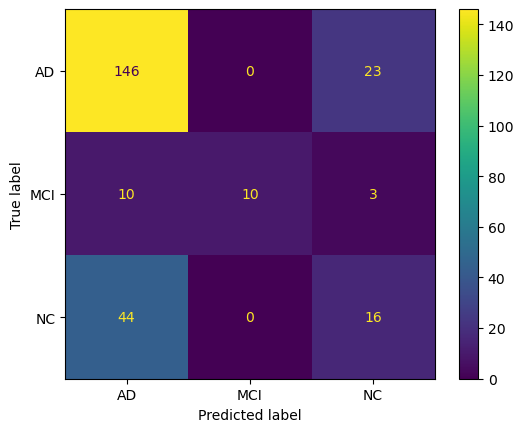

In [42]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_).plot()


In [43]:
import joblib
joblib.dump(best_model, "models/random_forest_mirna.pkl")


['models/random_forest_mirna.pkl']

#### Explainability section

In [44]:
import joblib, shap, pandas as pd, numpy as np
from pathlib import Path

model_path = Path("models/random_forest_mirna.pkl")
best_model = joblib.load(model_path)

DATA_PATH = Path("data/result/patient_full_embeddings.csv")
df      = pd.read_csv(DATA_PATH)

# replicate the same preprocessing as in the training phase
X   = df.drop(columns=["patient_id", "country", "disease", "age", "apoe4"])
y   = df["disease"]



In [45]:
# apply the same preprocessing (for the transformed features)
pre = best_model.named_steps["preprocess"]

feature_names = pre.get_feature_names_out()
print(len(feature_names))        


130


In [46]:
# Use shap.Explainer for tree-based models
explainer = shap.Explainer(
    best_model.named_steps["model"],          
    pre.transform(X),                         
    feature_names=feature_names,
    algorithm="tree"
)


 98%|===================| 740/756 [00:21<00:00]        

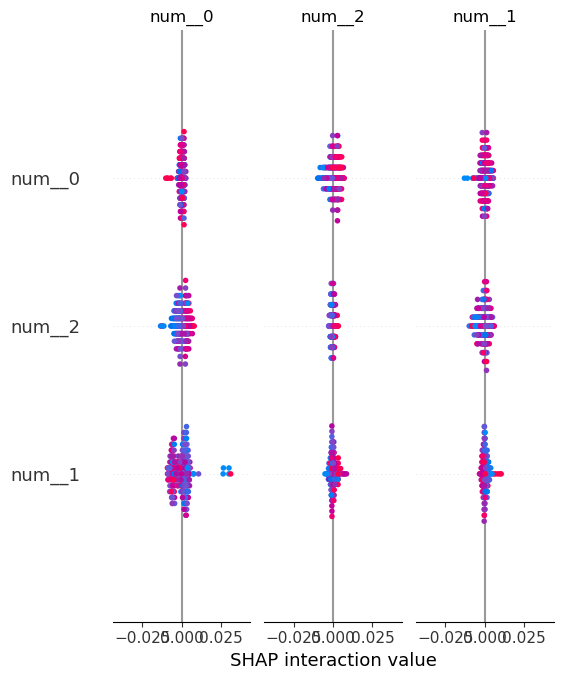

In [47]:
X_test_pre = pre.transform(X_test)

shap_values = explainer(X_test_pre, check_additivity=False)  

# graphical summary of SHAP values

shap.summary_plot(
    shap_values.values, X_test_pre, feature_names=feature_names,
    show=False                   
)


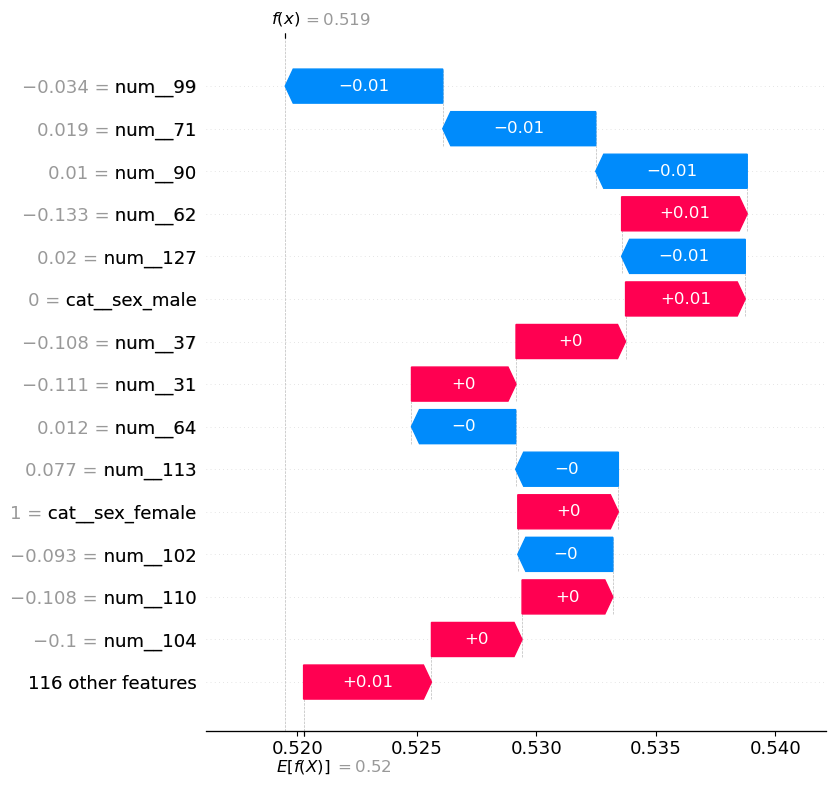

In [48]:
def explain_instance(i):
    pred = best_model.predict(X_test.iloc[[i]])[0]
    cls  = np.where(best_model.classes_ == pred)[0][0]
    ex   = shap.Explanation(
        values      = shap_values.values[i,:,cls],
        base_values = explainer.expected_value[cls],
        data        = X_test_pre[i],
        feature_names = feature_names
    )
    shap.plots.waterfall(ex, max_display=15)

# explain the instance at the specified index
explain_instance(0)


In [49]:
import numpy as np
import pandas as pd
import shap   

def top_features_for_instance(shap_vals, feature_names, idx, N=10, class_id=None, X_test_pre=None):
    """
    Returns a DataFrame with the N most influential features (in absolute value)
    for the instance `idx` and for the class `class_id`, including the value of the preprocessed feature.
    """
    sv = shap_vals.values if isinstance(shap_vals, shap.Explanation) else shap_vals

    if class_id is None:
        class_id = np.abs(sv[idx]).sum(axis=0).argmax()

    vals  = sv[idx, :, class_id]
    order = np.argsort(-np.abs(vals))[:N]

    features     = np.array(feature_names)[order]
    shap_values  = vals[order]
    directions   = ["+" if v > 0 else "-" for v in shap_values]

    # adding raw values if available
    raw_values = X_test_pre[idx][order] if X_test_pre is not None else ["?"] * N

    return pd.DataFrame({
        "feature"       : features,
        "shap_value"    : shap_values,
        "raw_value"     : raw_values,
        "direction (+ ⇒ pro‑class)" : directions
    })



Interpreting results:

- Positive SHAP value: the feature contributes to push the prediction towards the predicted class
- Negative SHAP value: the feature contributes to push the prediction away the predicted class

- Positive raw value: the feature has a higher value with respect to the preprocessing
- Negative raw value: the feature has a lower value with respect to the preprocessing

- +: the feature favors the predicted class
- -: the feature contrasts with the predicted class

In [50]:
idx = 0  # an example

pred_label = best_model.predict(X_test.iloc[[idx]])[0]
class_id   = np.where(best_model.classes_ == pred_label)[0][0]

df_top = top_features_for_instance(
    shap_values, feature_names, idx, N=15, class_id=class_id, X_test_pre=X_test_pre
)

df_top


,feature,shap_value,raw_value,direction (+ ⇒ pro‑class)
0,num__99,-0.006590,-0.034114,-
1,num__71,-0.006399,0.019246,-
2,num__90,-0.006336,0.009860,-
3,num__62,0.005255,-0.132879,+
4,num__127,-0.005173,0.020084,-
5,cat__sex_male,0.005007,0.000000,+
6,num__37,0.004582,-0.107724,+
7,num__31,0.004373,-0.111396,+
8,num__64,-0.004359,0.012276,-
9,num__113,-0.004295,0.076539,-


### Traning (Lasso coefficient) a Random Forest model

#### Computing the new dataset

In [123]:
# Extract dataframe containing for each patient a list of features weights
df_emb = pd.read_csv("data/raw/subj_embeddings_train.csv", index_col=0)

# Extract previously computed Lasso coefficients
df_lasso = pd.read_csv("data/result/lasso_coefficients.csv", index_col=0)

In [124]:
# convert the columns of df_emb to string type for further comparison
df_emb.columns = df_emb.columns.astype(str)

# align feature names of the two dataframes
df_lasso.index = df_lasso.index.str.replace("Feature_", "", regex=False)

# Secure the features present in both dataframes
common_feat = df_emb.columns.intersection(df_lasso.index)

df_emb_aligned   = df_emb[common_feat]               
df_lasso_aligned = df_lasso.loc[common_feat]         

In [125]:
df_new = df_emb_aligned.dot(df_lasso_aligned)  

In [126]:
df_new.to_csv("data/result/patient_miRNA_weights.csv")

print("Creato: data/result/patient_miRNA_weights.csv  "
      f"({df_new.shape[0]} pazienti × {df_new.shape[1]} miRNA)")

Creato: data/result/patient_miRNA_weights.csv  (1256 pazienti × 300 miRNA)


#### Reducing the Dataset for training purpose

In [127]:
W = pd.read_csv("data/result/lasso_coefficients.csv", index_col=0)

# compute the overall importance of each miRNA by summing the absolute values of the coefficients across all features
miRNA_score = W.abs().sum(axis=0).sort_values(ascending=False)

# Keep the miRNAs that explain at least 95% of the total weight
cum = miRNA_score.cumsum() / miRNA_score.sum()
keep = cum[cum <= 0.95].index       

print(f"Keeping {len(keep)} over {len(miRNA_score)} miRNA (≈95 % of cumulative importance)")

# Reduce the dataframe patients × miRNA
df_new = pd.read_csv("data/result/patient_miRNA_weights.csv", index_col=0)
df_new_sel = df_new[keep]

df_new_sel.to_csv("data/result/patient_miRNA_top.csv")

Keeping 101 over 300 miRNA (≈95 % of cumulative importance)


#### Extending the dataset with the patients information

In [128]:
import pandas as pd

# Load the two tables
df_info = pd.read_csv("data/result/patient_info.csv")          

# Selected miRNA expressions
df_mirna = pd.read_csv("data/result/patient_miRNA_top.csv", index_col=0)

df_mirna = df_mirna.rename_axis('patient_id').reset_index()

# perform the merge on patient_id, keeping only patients present in both tables (for security reasons)
df_merged = df_info.merge(df_mirna, on='patient_id', how='inner')

print(f"Output dataset: {df_merged.shape[0]} patients × {df_merged.shape[1]} columns")

df_merged.to_csv("data/result/patient_full_features.csv", index=False)


Output dataset: 1256 patients × 108 columns


#### Training the model based on lasso coefficients

In [129]:
RANDOM_STATE = 42

df = pd.read_csv("data/result/patient_full_features.csv")

# Remove patient_id column
df = df.drop(columns=["patient_id"])

y = df["disease"]
X = df.drop(columns=["disease"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

In [130]:
numeric_cols = X.select_dtypes(include=["number"]).columns
categorical_cols = X.select_dtypes(exclude=["number"]).columns   

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
    
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])

In [131]:
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("prep", preprocess),
    ("rf",   rf)
])

In [132]:
param_grid = {
    "rf__n_estimators":   [300, 500, 800],
    "rf__max_depth":      [None, 10, 20],
    "rf__min_samples_leaf": [1, 2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV f1-macro:", grid.best_score_.round(3))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'rf__max_depth': 10, 'rf__min_samples_leaf': 4, 'rf__n_estimators': 800}
CV f1-macro: 0.676


In [133]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("\n=== Test-set metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred).round(3))
print("F1-macro :", f1_score(y_test, y_pred, average="macro").round(3))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


=== Test-set metrics ===
Accuracy : 0.726
F1-macro : 0.618

Classification report:
              precision    recall  f1-score   support

          AD      0.763     0.876     0.815       169
         MCI      1.000     0.391     0.562        23
          NC      0.531     0.433     0.477        60

    accuracy                          0.726       252
   macro avg      0.764     0.567     0.618       252
weighted avg      0.729     0.726     0.712       252

Confusion matrix:
 [[148   0  21]
 [ 12   9   2]
 [ 34   0  26]]


In [134]:
y_pred_lasso = y_pred

### Verifying correspondence between models

At this moment: between

- original dataset and lasso dataset

In [135]:


def compare_predictions(
        pred_base,
        pred_comp,
        y_true: Optional[pd.Series] = None,
        classes: List[str] = ("AD", "MCI", "NC"),
        digits: int = 2
    ) -> Dict[str, float]:
    """
    Compare two prediction vectors (base vs. comparison) and optionally
    the true labels. Returns a dictionary of percentages.

    ▸ pred_base  : predictions of the base model
    ▸ pred_comp  : predictions of the comparison model
    ▸ y_true     : (opz.) real labels to check correctness
    ▸ classes    : list of classes
    """

    pred_base  = pd.Series(pred_base).reset_index(drop=True)
    pred_comp  = pd.Series(pred_comp).reset_index(drop=True)

    if len(pred_base) != len(pred_comp):
        raise ValueError("Le predizioni hanno lunghezze diverse")

    same_pred_mask = (pred_base == pred_comp)
    pct_same_pred  = same_pred_mask.mean() * 100

    pct_same_correct = None
    if y_true is not None:
        y_true = pd.Series(y_true).reset_index(drop=True)
        if len(y_true) != len(pred_base):
            raise ValueError("y_true deve avere la stessa lunghezza delle predizioni")
        pct_same_correct = (same_pred_mask & (pred_base == y_true)).mean() * 100

    pct_class_same = {
        cls: ((pred_base == cls) & (pred_comp == cls)).mean() * 100
        for cls in classes
    }

    cond_agree = {}
    for cls in classes:
        mask_ref = (pred_base == cls)
        if mask_ref.sum() == 0:
            cond_agree[cls] = float("nan")
        else:
            cond_agree[cls] = (pred_comp[mask_ref] == cls).mean() * 100

    print(f"Corresponding predictions ..................: {pct_same_pred:.{digits}f}%")
    if pct_same_correct is not None:
        print(f"Corresponding and correct predictions ..: {pct_same_correct:.{digits}f}%")
    for cls in classes:
        print(f" · Global concordance '{cls}'    : {pct_class_same[cls]:.{digits}f}%")
    for cls in classes:
        n_ref = (pred_base == cls).sum()
        print(f" · Conditioned on ='{cls}' (n={n_ref}) -> "
              f"{cond_agree[cls]:.{digits}f}%")

    return {
        "pct_same_pred": pct_same_pred,
        "pct_same_correct": pct_same_correct,
        "pct_class_same": pct_class_same,
        "conditional_agreement": cond_agree
    }


In [136]:
# Comparison #1: y_pred_std vs. y_pred_lasso

metrics = compare_predictions(
    y_pred_std,        
    y_pred_lasso,      
    y_true=y_test      
)

Corresponding predictions ..................: 92.46%
Corresponding and correct predictions ..: 70.24%
 · Global concordance 'AD'    : 75.40%
 · Global concordance 'MCI'    : 3.57%
 · Global concordance 'NC'    : 13.49%
 · Conditioned on ='AD' (n=205) -> 92.68%
 · Conditioned on ='MCI' (n=10) -> 90.00%
 · Conditioned on ='NC' (n=37) -> 91.89%


### Mappping miRNA influence over a prediction based on extracted features

In [51]:
import re
import pandas as pd
import numpy as np


In [52]:
mapping_df = pd.read_csv(
    "data/result/pruned_lasso_coefficients_nonzero.csv",
    index_col=0          
)


In [53]:
# def shap_to_mirna_with_pred(
#         x_raw_row: pd.DataFrame,
#         best_model,
#         shap_vals,
#         feature_names: list[str],
#         mapping_df: pd.DataFrame,
#         idx: int,
#         top_n_feat: int | None = None
#     ) -> tuple[dict, pd.DataFrame]:
#     import re, numpy as np, pandas as pd, shap

#     # ---------- ①  inferenza del modello ----------
#     proba = best_model.predict_proba(x_raw_row)[0]
#     classes = best_model.classes_
#     pred_label = classes[np.argmax(proba)]
#     pred_info = {
#         "predicted_label": pred_label,
#         "probabilities": dict(zip(classes, proba.round(4)))
#     }

#     # ---------- ②  costruisci DataFrame SHAP per la singola riga ----------
#     sv = shap_vals.values if isinstance(shap_vals, shap.Explanation) else shap_vals
#     data = shap_vals.data if isinstance(shap_vals, shap.Explanation) else None

#     class_id = np.where(classes == pred_label)[0][0]
#     shap_vec = sv[idx, :, class_id]

#     shap_df = pd.DataFrame({
#         "feature": feature_names,
#         "shap_value": shap_vec,
#         "raw_value": data[idx] if data is not None else [np.nan] * len(feature_names)  # nuova colonna
#     }).assign(abs_val=lambda d: d.shap_value.abs()) \
#       .sort_values("abs_val", ascending=False) \
#       .drop(columns="abs_val")

#     if top_n_feat is not None:
#         shap_df = shap_df.head(top_n_feat)

#     # ---------- ③  aggrega sulle espressioni miRNA ----------
#     total = pd.Series(0.0, index=mapping_df.columns)

#     for _, row in shap_df.iterrows():
#         m = re.search(r'(\d+)', row["feature"])
#         feat_key = f"Feature_{m.group(1)}" if m else row["feature"]

#         if feat_key in mapping_df.index:
#             total = total.add(mapping_df.loc[feat_key] * row["shap_value"], fill_value=0.0)

#     mirna_df = (
#         total[total != 0]
#         .sort_values(ascending=False)
#         .rename("aggregated_weight")
#         .reset_index()
#         .rename(columns={"index": "miRNA"})
#     )

#     return pred_info, mirna_df


In [54]:
# idx = 0
# x_row = X_test.iloc[[idx]]                       # riga grezza
# pred_info, mirna_df = shap_to_mirna_with_pred(
#     x_row, best_model, shap_values, feature_names,
#     mapping_df, idx, top_n_feat=50
# )

# print(pred_info)        # {'predicted_label': 'NC', 'probabilities': {'AD': 0.433, ...}}
# mirna_df.head(10)       # tabella miRNA ↔ peso aggregato


In [55]:
# print(mirna_df.head(10))  # (k, 2) con k miRNA e i loro pesi aggregati

In [56]:
def mirna_explain(
        shap_df: pd.DataFrame,      # feature, shap_value, raw_value
        mapping_df: pd.DataFrame,
        top_k_feat_per_mirna: int = 3
    ) -> pd.DataFrame:
    """
    Aligning explainability at feature-level and miRNA-level.

    Parameters
    ----------
    shap_df : DataFrame with columns ['feature', 'shap_value', 'raw_value'].
    mapping_df : DataFrame idx='Feature_x', columns=miRNA, values=coeff.
    top_k_feat_per_mirna : how many feature names to return (stringa "feat1, feat2 ...").

    Returns
    -------
    df_mirna : miRNA, aggregated_weight, agg_raw, n_features, top_features
    """
    import re
    from collections import defaultdict
    import numpy as np
    import pandas as pd

    agg_weight  = defaultdict(float)    # aggregated SHAP weights per miRNA
    agg_raw     = defaultdict(float)    # aggregated raw values per miRNA
    feat_list   = defaultdict(list)     # list of most influent features per miRNA

    for _, row in shap_df.iterrows():
        # processing (needed to match the mapping_df index)
        m = re.search(r'(\d+)', row['feature'])
        feat_key = f"Feature_{m.group(1)}" if m else row['feature']
        if feat_key not in mapping_df.index:
            continue

        coeff_series = mapping_df.loc[feat_key]

        # update aggregated values
        agg_weight.update({mi: agg_weight[mi] + coeff_series[mi] * row['shap_value']
                           for mi in coeff_series.index})
        agg_raw.update({mi: agg_raw[mi] + coeff_series[mi] * row['raw_value']
                        for mi in coeff_series.index})
        for mi in coeff_series.index:
            if len(feat_list[mi]) < top_k_feat_per_mirna:
                feat_list[mi].append(row['feature'])

    df = (
        pd.DataFrame({
            "miRNA":   agg_weight.keys(),
            "aggregated_weight": agg_weight.values(),
            "agg_raw": [agg_raw[mi] for mi in agg_weight.keys()],
            "n_features": [len(feat_list[mi]) for mi in agg_weight.keys()],
            "top_features": [", ".join(feat_list[mi]) for mi in agg_weight.keys()]
        })
        .query("aggregated_weight != 0")
        .sort_values("aggregated_weight", ascending=False)
        .reset_index(drop=True)
    )
    return df


In [57]:
shap_df = top_features_for_instance(
    shap_values, feature_names, idx,
    N=50, class_id=class_id, X_test_pre=X_test_pre
)

mirna_detailed = mirna_explain(shap_df, mapping_df, top_k_feat_per_mirna=3)

mirna_detailed.head(10)


,miRNA,aggregated_weight,agg_raw,n_features,top_features
0,hsa-miR-6729-5p,0.014075,-0.497379,3,"num__99, num__71, num__90"
1,hsa-miR-6087,0.011537,-0.224408,3,"num__99, num__71, num__90"
2,hsa-miR-4734,0.007556,-0.173915,3,"num__99, num__71, num__90"
3,hsa-miR-2861,0.007170,-0.339141,3,"num__99, num__71, num__90"
4,hsa-miR-7704,0.004836,-0.293968,3,"num__99, num__71, num__90"
5,hsa-miR-6895-5p,0.003654,-0.094336,3,"num__99, num__71, num__90"
6,hsa-miR-1268a,0.003214,0.003140,3,"num__99, num__71, num__90"
7,hsa-miR-3663-3p,0.003198,-0.105186,3,"num__99, num__71, num__90"
8,hsa-miR-3665,0.003065,-0.097079,3,"num__99, num__71, num__90"
9,hsa-miR-6090,0.003022,-0.180249,3,"num__99, num__71, num__90"
